# Bam Pol II ChIP-Seq (Dustin E Schones)

In [1]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from pybedtools import BedTool
from pybedtools.featurefuncs import gff2bed, five_prime
from gffutils import FeatureDB
from gffutils.helpers import asinterval

# Project level imports
from larval_gonad.notebook import Nb
from larval_gonad.x_to_a import CHROMS_CHR

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook()

last updated: 2018-07-19 
Git hash: 55eaa1b846a2d31b9f1f46937e53a1f587c28c00


In [3]:
# Make a gene level bed
db = FeatureDB('/data/LCDB/lcdb-references/dmel/r6-16/gtf/dmel_r6-16.gtf.db')
genesBed = []
for gene in db.features_of_type('gene'):
    genesBed.append(gff2bed(asinterval(gene)))

geneBt = BedTool(genesBed)

/home/fearjm/miniconda3/envs/larval_gonad/lib/python3.6/site-packages/gffutils/interface.py:161: UserWarning: It appears that this database has not had the ANALYZE sqlite3 command run on it. Doing so can dramatically speed up queries, and is done by default for databases created with gffutils >0.8.7.1 (this database was created with version 0.8.7.1) Consider calling the analyze() method of this object.
  "method of this object." % self.version)


In [4]:
tss = []
for g in geneBt:
    tss.append(five_prime(g))
tssBt = BedTool(tss)

## Bam

In [5]:
# Import peaks
fname = '../public-chip-wf/data/GSM480449_dm3-bam-PolII_lifted_dm6.bed'
bed = BedTool(fname).sort()

pos = bed.merge(s=True, S='+')
neg = bed.merge(s=True, S='-')

munge = []
for i in pos:
    munge.append(i.fields + ['.', '.', '+'])
for i in neg:
    munge.append(i.fields + ['.', '.', '-'])

merged = BedTool(munge)

In [6]:
overlap = geneBt.intersect(merged, wo=True, s=True)

res = []
for i in overlap:
    res.append((i.name, i.length, int(i.fields[-1])))

df = pd.DataFrame(res, columns=['name', 'length', 'overlap'])
dfOver = df.groupby('name').agg({'length': 'first', 'overlap': 'sum'})
prop = dfOver.overlap / dfOver.length
prop.name = 'prop'

datBam = prop.to_frame().join(nbconfig.fbgn2chrom)

In [7]:
overlap = tssBt.intersect(merged, wo=True, s=True)

res = []
for i in overlap:
    res.append((i.name, i.length, int(i.fields[-1])))

df = pd.DataFrame(res, columns=['name', 'length', 'overlap'])
dfOver = df.groupby('name').agg({'length': 'first', 'overlap': 'sum'})
prop = dfOver.overlap / dfOver.length
prop.name = 'prop'

tssBam = prop.to_frame().join(nbconfig.fbgn2chrom)

## S2

In [8]:
# Import peaks
fname = '../public-chip-wf/data/GSM480449_dm3-S2-PolII_lifted_dm6.bed'
bed = BedTool(fname).sort()

pos = bed.merge(s=True, S='+')
neg = bed.merge(s=True, S='-')

munge = []
for i in pos:
    munge.append(i.fields + ['.', '.', '+'])
for i in neg:
    munge.append(i.fields + ['.', '.', '-'])

merged = BedTool(munge)

In [9]:
overlap = geneBt.intersect(merged, wo=True, s=True)

res = []
for i in overlap:
    res.append((i.name, i.length, int(i.fields[-1])))

df = pd.DataFrame(res, columns=['name', 'length', 'overlap'])
dfOver = df.groupby('name').agg({'length': 'first', 'overlap': 'sum'})
prop = dfOver.overlap / dfOver.length
prop.name = 'prop'

datS2 = prop.to_frame().join(nbconfig.fbgn2chrom)

In [10]:
overlap = tssBt.intersect(merged, wo=True, s=True)

res = []
for i in overlap:
    res.append((i.name, i.length, int(i.fields[-1])))

df = pd.DataFrame(res, columns=['name', 'length', 'overlap'])
dfOver = df.groupby('name').agg({'length': 'first', 'overlap': 'sum'})
prop = dfOver.overlap / dfOver.length
prop.name = 'prop'

tssS2 = prop.to_frame().join(nbconfig.fbgn2chrom)

## Plot

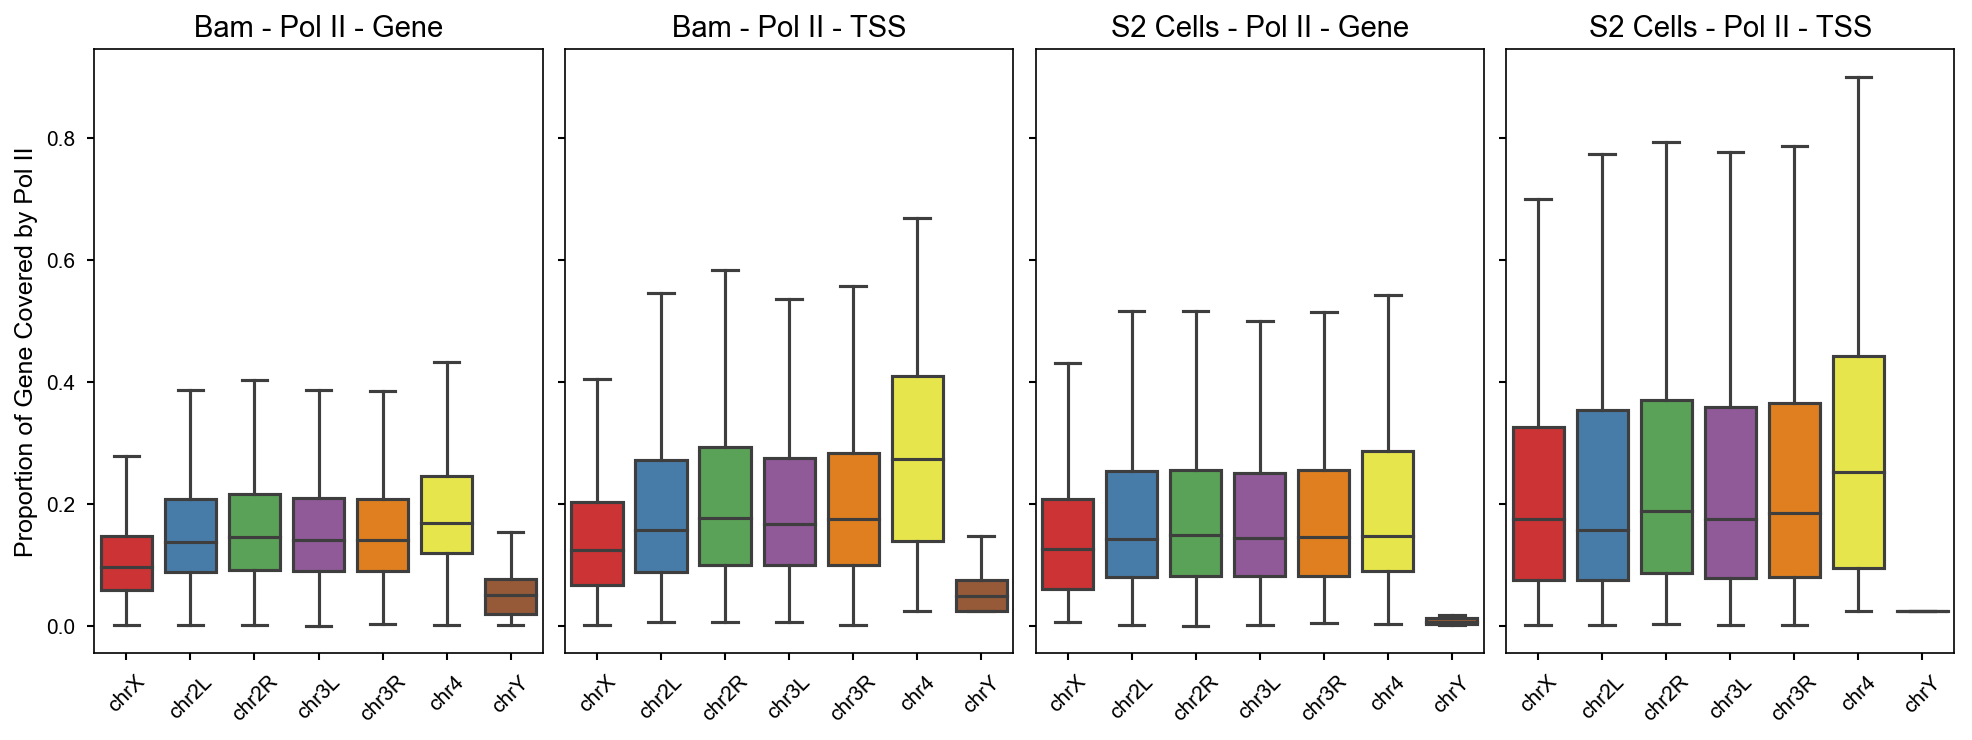

In [11]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=plt.figaspect(1/3), sharex=True, sharey=True, gridspec_kw={'wspace': 0.05})
sns.boxplot('chrom', 'prop', data=datBam, palette=nbconfig.colors['chrom'], showfliers=False, order=CHROMS_CHR, ax=ax1)
ax1.set_xlabel('Chromosome')
ax1.set_ylabel('')
ax1.set_title('Bam - Pol II - Gene')
ax1.set_xlabel('')
ax1.set_ylabel('Proportion of Gene Covered by Pol II')

sns.boxplot('chrom', 'prop', data=tssBam, palette=nbconfig.colors['chrom'], showfliers=False, order=CHROMS_CHR, ax=ax2)
ax2.set_xlabel('Chromosome')
ax2.set_title('Bam - Pol II - TSS')
ax2.set_xlabel('')
ax2.set_ylabel('')

sns.boxplot('chrom', 'prop', data=datS2, palette=nbconfig.colors['chrom'], showfliers=False, order=CHROMS_CHR, ax=ax3)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('S2 Cells - Pol II - Gene')

sns.boxplot('chrom', 'prop', data=tssS2, palette=nbconfig.colors['chrom'], showfliers=False, order=CHROMS_CHR, ax=ax4)
ax4.set_xlabel('')
ax4.set_ylabel('')
ax4.set_title('S2 Cells - Pol II - TSS')

plt.setp(ax1.get_xticklabels(), rotation=45)
plt.setp(ax2.get_xticklabels(), rotation=45)
plt.setp(ax3.get_xticklabels(), rotation=45)
plt.setp(ax4.get_xticklabels(), rotation=45);

In [12]:
from scipy.stats import mannwhitneyu

In [13]:
mannwhitneyu(datBam.query('chrom == "chrX"').prop, tssBam.query('chrom == "chrX"').prop)

MannwhitneyuResult(statistic=2459072.0, pvalue=2.7731485356935884e-24)

In [14]:
mannwhitneyu(datS2.query('chrom == "chrX"').prop, tssS2.query('chrom == "chrX"').prop)

MannwhitneyuResult(statistic=2404211.0, pvalue=1.4633483896713772e-27)

In [15]:
mannwhitneyu(datBam.query('chrom == "chr3R"').prop, datBam.query('chrom == "chr3L"').prop)

MannwhitneyuResult(statistic=6538980.0, pvalue=0.45326449475463976)

In [31]:
datBam.query('chrom == "chrX"').shape[0] / nbconfig.fbgn2chrom.query('chrom == "chrX"').shape[0]

0.8973398276508056

In [26]:
tssBam.query('chrom == "chrX"').shape[0]

2466

In [27]:
datS2.query('chrom == "chrX"').shape[0]

2389

In [28]:
tssS2.query('chrom == "chrX"').shape[0]

2453

In [29]:
nbconfig.fbgn2chrom.query('chrom == "chrX"').shape[0]

2669

In [30]:
datBam.query('chrom == "chrX"')

,prop,chrom
name,,
FBgn0000022,0.073064,chrX
FBgn0000028,0.037674,chrX
FBgn0000042,0.395902,chrX
FBgn0000077,0.220113,chrX
FBgn0000084,0.091787,chrX
FBgn0000092,0.134199,chrX
FBgn0000108,0.048101,chrX
FBgn0000117,0.145576,chrX
FBgn0000137,0.051029,chrX
